# Riemannian VAE Frechet

In [1]:
#Modules
import jax.numpy as jnp
import jax.random as jrandom
from jax import vmap, jit

import numpy as np

import haiku as hk

import torch
import torchvision.utils as vutils

import pickle

from abc import ABC

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.ticker as tkr

import os

from geometry.riemannian.frechet_mean import GEORCE_FM

from load_manifold import load_manifold
from vae.model_loader import mnist_generator, svhn_generator, celeba_generator, load_model

from vae.models import mnist_encoder
from vae.models import mnist_decoder
from vae.models import mnist_vae

from vae.models import svhn_encoder
from vae.models import svhn_decoder
from vae.models import svhn_vae

from vae.models import celeba_encoder
from vae.models import celeba_decoder
from vae.models import celeba_vae

2025-02-10 01:42:04.380603: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [14]:
plt.rcParams.update({'font.size': 12})
cbformat = tkr.ScalarFormatter()   # create the formatter
cbformat.set_powerlimits((-2,2)) 

In [15]:
seed = 2712
model_path = 'models/'

In [16]:
device = 'gpu'
geometry = "riemannian"
batch_size = '10'
path = f'timing_{device}/{geometry}/'
figure_path = '../figures/vae/frechet/'

In [17]:
if not (os.path.exists(figure_path)):
    os.makedirs(figure_path)

## Loading Values

In [18]:
def load_manifold_data(manifold:str, dim):
    
    save_path = ''.join((path, manifold, '/'))
    
    onlyfiles = [f for f in os.listdir(save_path) if os.path.isfile(os.path.join(save_path, f))]
    onlyfiles = [f for f in onlyfiles if f'batch={batch_size}.pkl' in f]
    
    estimates = {}
    for file in onlyfiles:
        file_path = ''.join((save_path, file))
        with open(file_path, 'rb') as f:
            values = pickle.load(f)
        method = file.split(f'_{manifold}')[0]
        dim = file.replace(f"{method}_", '').replace(manifold, '').replace('.pkl', '').replace('_d=', '').replace(f'_batch={batch_size}', '')
        if dim in estimates:
            estimates[dim] = dict(estimates[dim], **values)
        else:
            estimates[dim] = values
            
    return estimates
    

## VAE MNIST

In [19]:
latent_dim = 8

### Loading Data

In [20]:
mnist_dataloader = mnist_generator(seed=2712,
                                   batch_size=64,
                                   split='train[:80%]')

2025-02-10 01:42:20.741479: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
mnist_method = load_manifold_data("mnist", dim=latent_dim)[str(latent_dim)]

In [22]:
mnist_obs, M_mnist, _ = load_manifold("mnist", dim=latent_dim, N_data=10)

### Loading Model

In [23]:
@hk.transform
def mnist_tvae(x):


    vae = mnist_vae(
                encoder=mnist_encoder(latent_dim=latent_dim),
                decoder=mnist_decoder(),
    )

    return vae(x)

@hk.transform
def mnist_tencoder(x):


    encoder = mnist_encoder(latent_dim=latent_dim)

    return encoder(x)[0]

@hk.transform
def mnist_tdecoder(x):

    decoder = mnist_decoder()

    return decoder(x)

In [24]:
mnist_state = load_model(''.join((model_path, f'mnist_{latent_dim}/')))

In [25]:
mnist_encoder_fun = lambda x: mnist_tencoder.apply(mnist_state.params, None, x.reshape(-1,
                                                                                       28,
                                                                                       28,
                                                                                       1)).reshape(-1,
                                                                                                   latent_dim).squeeze()
mnist_decoder_fun = lambda x: mnist_tdecoder.apply(mnist_state.params, None, x.reshape(-1,
                                                                                       latent_dim)).reshape(-1,
                                                                                                            28*28).squeeze()
mnist_vae_fun = lambda x: mnist_tvae.apply(mnist_state.params, mnist_state.rng_key, x)

In [26]:
mnist_data = next(mnist_dataloader).x

### Plotting Reconstruction

In [27]:
mnist_data = next(mnist_dataloader).x

In [28]:
mnist_rec = mnist_vae_fun(mnist_data)

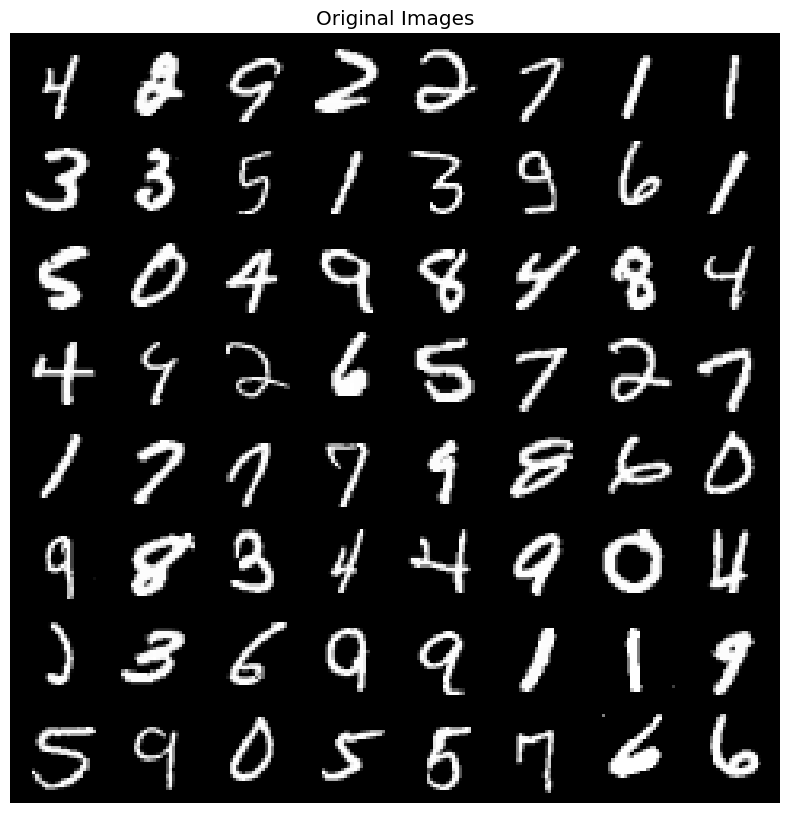

In [29]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

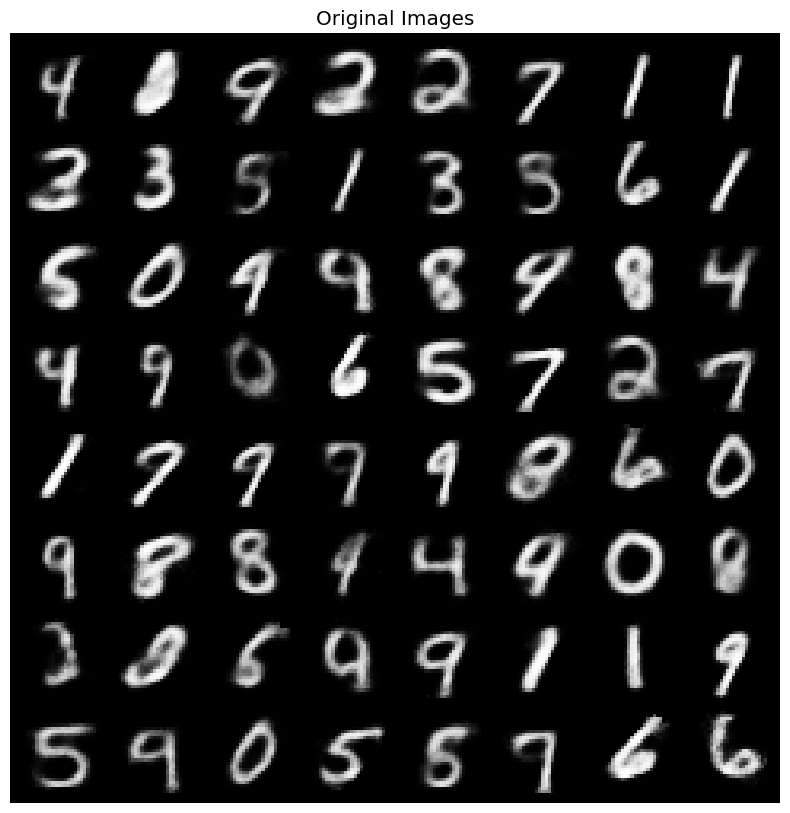

In [30]:
plot_val = torch.from_numpy(np.transpose(np.array(mnist_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Plotting

In [33]:
mnist_obs = M_mnist.f(mnist_obs)
mnist_mu = M_mnist.f(mnist_method['GEORCE_FM']['mu'])
plot_val = torch.from_numpy(np.transpose(np.array(mnist_obs.reshape(-1,28,28,1)), (0,3,1,2)))
mu_plot = torch.from_numpy(np.transpose(np.array(mnist_mu.reshape(-1,28,28,1)), (0,3,1,2)))
plot_val = torch.concatenate((plot_val,
                               mu_plot),
                               axis=0)

In [ ]:
img_height = 28+2
plot_grid = T//10
tick_list = [img_height/2+j*img_height for j in range(len(mnist_methods))]
xt = jnp.stack([jnp.vstack((value['xt'][::plot_grid][:-1], value['xt'][-1])) for key, value in mnist_methods.items()]).reshape(-1,28,28,1)
length = [f"{key}({value['idx']}): {value['length']:.4f}" for key, value in mnist_methods.items()]
tick_xlist = [img_height/2+j*img_height for j in range(len())]
grid_index = [f"t={int(plot_grid*i)}" for i in range(len(mnist_methods['GEORCE']['xt'][::plot_grid]))]
grid_index[-1] = f"t={T+1}"

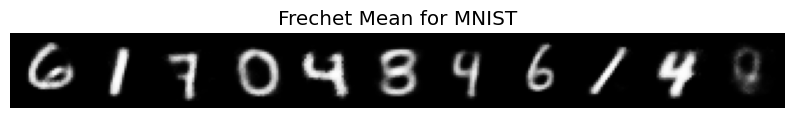

In [34]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Frechet Mean for MNIST")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, nrow=len(plot_val), normalize=True).cpu(),(1,2,0)))

## VAE SVHN

In [35]:
latent_dim = 32

### Loading Data

In [36]:
svhn_dataloader = svhn_generator(data_dir="../../../Data/SVHN/",
                                 batch_size=64,
                                 seed=2712,
                                 split='train[:80%]')

In [37]:
svhn_method = load_manifold_data("svhn", dim=latent_dim)[str(latent_dim)]

In [50]:
svhn_obs, M_svhn, _ = load_manifold("svhn", dim=latent_dim, N_data=10)

### Loading Model

In [52]:
@hk.transform
def svhn_tvae(x):


    vae = svhn_vae(
                encoder=svhn_encoder(latent_dim=latent_dim),
                decoder=svhn_decoder(),
    )

    return vae(x)

@hk.transform_with_state
def svhn_tencoder(x):


    encoder = svhn_encoder(latent_dim=latent_dim)

    return encoder(x)

@hk.transform_with_state
def svhn_tdecoder(x):

    decoder = svhn_decoder(latent_dim=latent_dim)

    return decoder(x)

In [53]:
svhn_state = load_model(''.join((model_path, f'svhn_{latent_dim}/')))

In [54]:
svhn_encoder_fun = lambda x: svhn_tencoder.apply(svhn_state.params, svhn_state.rng_key, x)
svhn_decoder_fun = lambda x: svhn_tdecoder.apply(svhn_state.params, svhn_state.rng_key, x)
svhn_vae_fun = lambda x: svhn_tvae.apply(svhn_state.params, svhn_state.rng_key, x)

### Plotting Reconstruction

In [55]:
svhn_data = next(svhn_dataloader).x

In [56]:
svhn_rec = svhn_vae_fun(svhn_data)

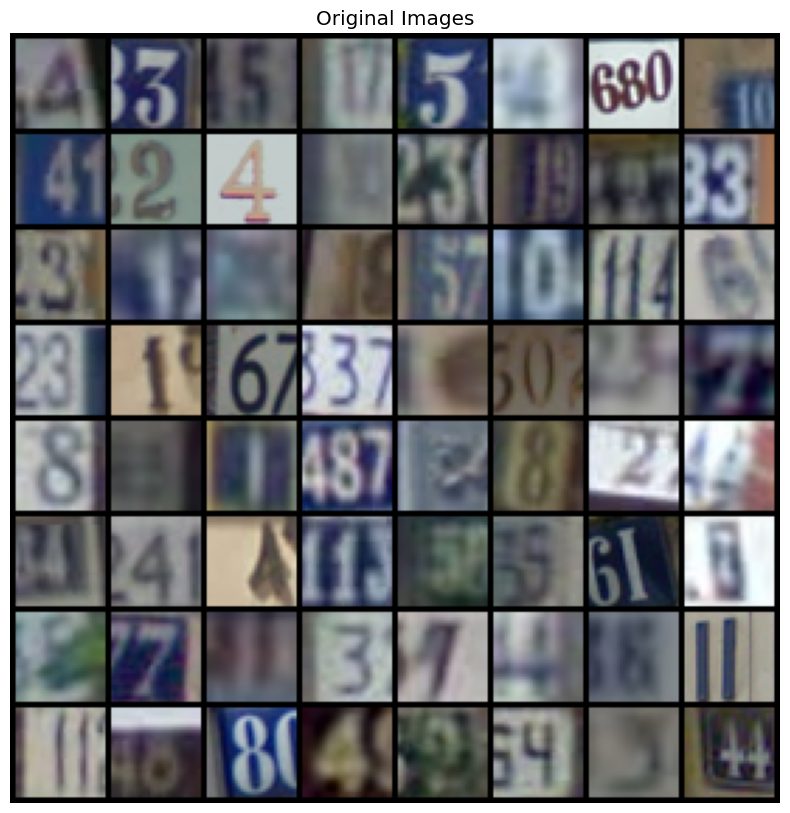

In [57]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

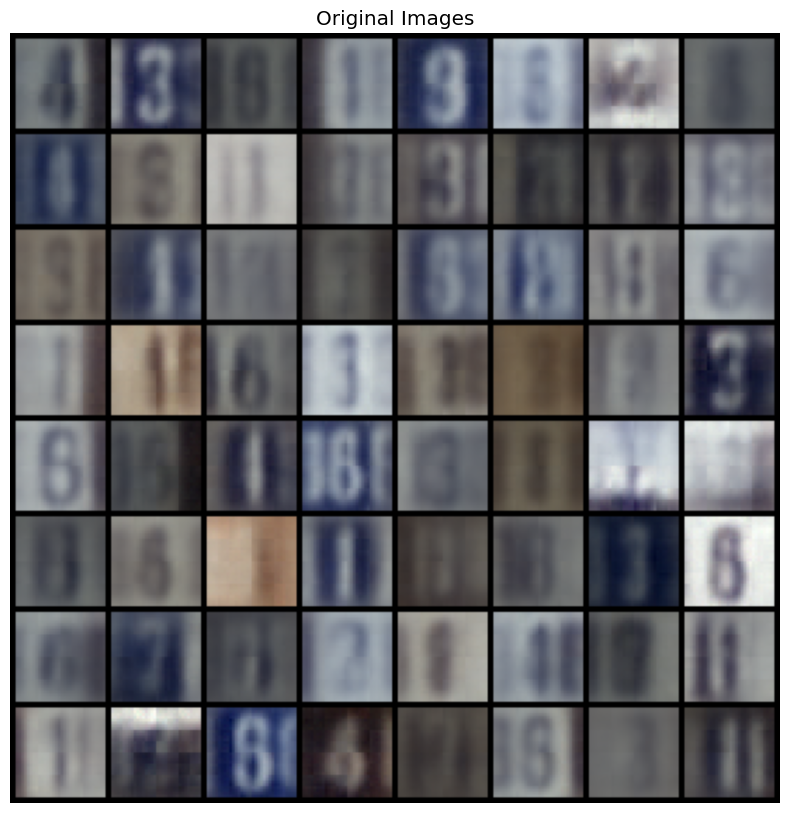

In [58]:
plot_val = torch.from_numpy(np.transpose(np.array(svhn_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Plotting

In [59]:
svhn_obs = vmap(M_svhn.f)(svhn_obs)
svhn_mu = M_svhn.f(svhn_method['GEORCE_FM']['mu'])
plot_val = torch.from_numpy(np.transpose(np.array(svhn_obs.reshape(-1,32,32,3)), (0,3,1,2)))
mu_plot = torch.from_numpy(np.transpose(np.array(svhn_mu.reshape(-1,32,32,3)), (0,3,1,2)))
plot_val = torch.concatenate((plot_val,
                               mu_plot),
                               axis=0)

In [60]:
plot_val.shape

torch.Size([11, 3, 32, 32])

In [61]:
img_height = 28+2
plot_grid = T//10
tick_list = [img_height/2+j*img_height for j in range(len(mnist_methods))]
xt = jnp.stack([jnp.vstack((value['xt'][::plot_grid][:-1], value['xt'][-1])) for key, value in mnist_methods.items()]).reshape(-1,28,28,1)
length = [f"{key}({value['idx']}): {value['length']:.4f}" for key, value in mnist_methods.items()]
tick_xlist = [img_height/2+j*img_height for j in range(len())]
grid_index = [f"t={int(plot_grid*i)}" for i in range(len(mnist_methods['GEORCE']['xt'][::plot_grid]))]
grid_index[-1] = f"t={T+1}"

NameError: name 'T' is not defined

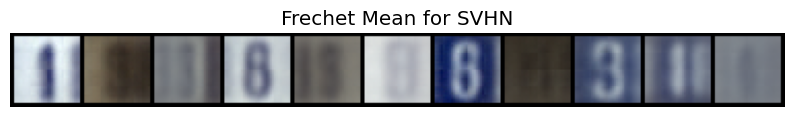

In [62]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Frechet Mean for SVHN")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, nrow=len(plot_val), normalize=True).cpu(),(1,2,0)))

## VAE CelebA

In [111]:
latent_dim = 32

### Loading Data

In [112]:
celeba_dataloader = celeba_generator(data_dir="../../../Data/CelebA/",
                                     batch_size=64,
                                     seed=2712, 
                                     split=0.8)

In [113]:
celeba_method = load_manifold_data("celeba", dim=latent_dim)[str(latent_dim)]

In [114]:
celeba_zobs, M_celeba, _ = load_manifold("celeba", dim=latent_dim, N_data=10)

### Loading Model

In [115]:
@hk.transform
def celeba_tvae(x):


    vae = celeba_vae(
                encoder=celeba_encoder(latent_dim=latent_dim),
                decoder=celeba_decoder(),
    )

    return vae(x)

@hk.transform
def celeba_tencoder(x):


    encoder = celeba_encoder(latent_dim=latent_dim)

    return encoder(x)

@hk.transform
def celeba_tdecoder(x):

    decoder = celeba_decoder(latent_dim=latent_dim)

    return decoder(x)

In [116]:
celeba_state = load_model(''.join((model_path, f'celeba_{latent_dim}/')))

In [117]:
celeba_encoder_fun = lambda x: celeba_tencoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_decoder_fun = lambda x: celeba_tdecoder.apply(celeba_state.params, celeba_state.rng_key, x)
celeba_vae_fun = lambda x: celeba_tvae.apply(celeba_state.params, celeba_state.rng_key, x)

### Plotting Reconstruction

In [118]:
celeba_data = next(celeba_dataloader).x

In [119]:
celeba_rec = celeba_vae_fun(celeba_data)

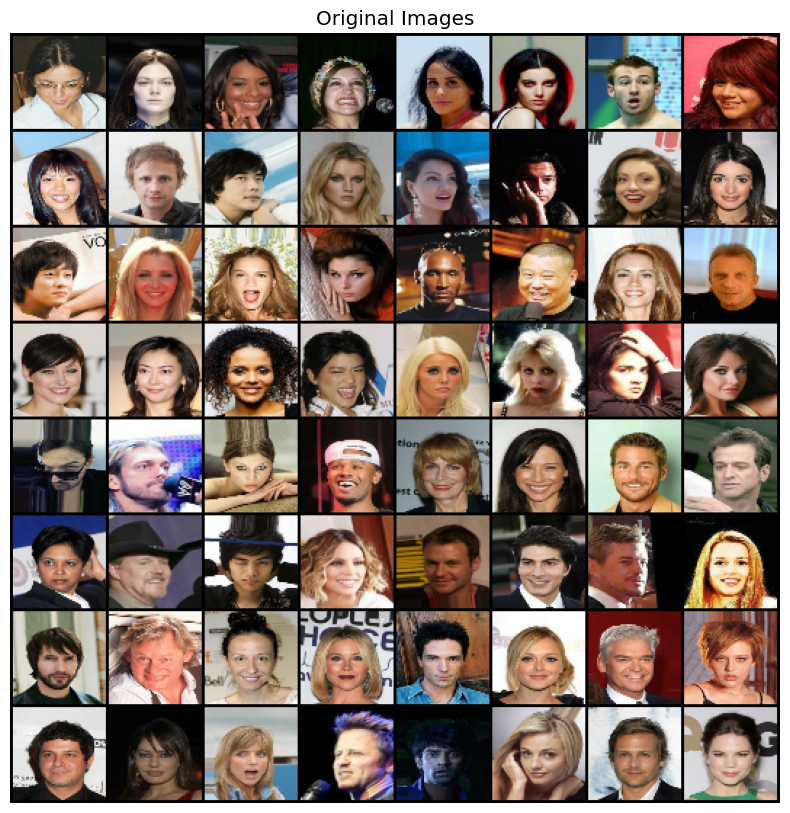

In [120]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_data), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

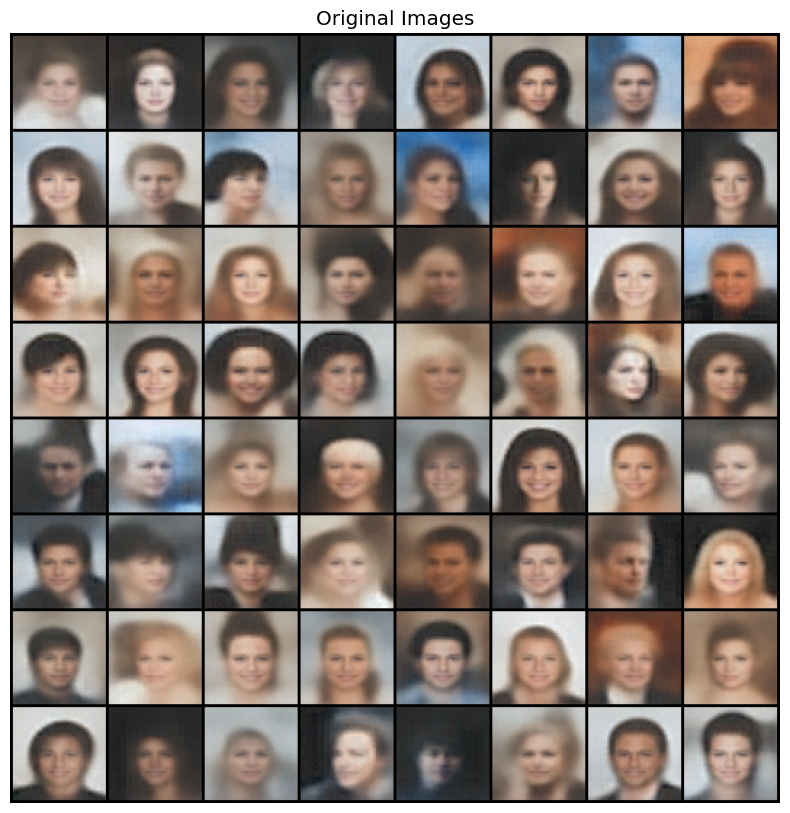

In [121]:
plot_val = torch.from_numpy(np.transpose(np.array(celeba_rec.mu_xz), (0,3,1,2)))
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Original Images")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, normalize=True).cpu(),(1,2,0)))

### Plotting

In [122]:
celeba_xobs = vmap(M_celeba.f)(celeba_zobs)
celeba_mu = M_celeba.f(celeba_method['GEORCE_FM']['mu'])
plot_val = torch.from_numpy(np.transpose(np.array(celeba_xobs.reshape(-1,64,64,3)), (0,3,1,2)))
mu_plot = torch.from_numpy(np.transpose(np.array(celeba_mu.reshape(-1,64,64,3)), (0,3,1,2)))
plot_val = torch.concatenate((plot_val,
                               mu_plot),
                               axis=0)

In [61]:
img_height = 28+2
plot_grid = T//10
tick_list = [img_height/2+j*img_height for j in range(len(mnist_methods))]
xt = jnp.stack([jnp.vstack((value['xt'][::plot_grid][:-1], value['xt'][-1])) for key, value in mnist_methods.items()]).reshape(-1,28,28,1)
length = [f"{key}({value['idx']}): {value['length']:.4f}" for key, value in mnist_methods.items()]
tick_xlist = [img_height/2+j*img_height for j in range(len())]
grid_index = [f"t={int(plot_grid*i)}" for i in range(len(mnist_methods['GEORCE']['xt'][::plot_grid]))]
grid_index[-1] = f"t={T+1}"

NameError: name 'T' is not defined

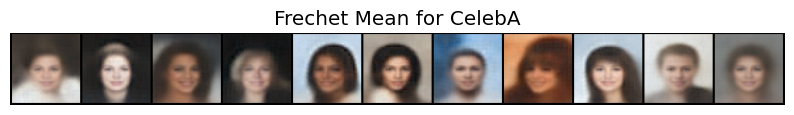

In [123]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.set_axis_off()
ax.set_title("Frechet Mean for CelebA")
ax.imshow(np.transpose(vutils.make_grid(plot_val, padding=2, nrow=len(plot_val), normalize=True).cpu(),(1,2,0)))

In [124]:
from geometry.riemannian.geodesics import GEORCE

In [127]:
Geodesic = jit(GEORCE(M=M_celeba,
                      init_fun=None,
                      T=100,
                      max_iter=10,
                      line_search_method="soft",
                      line_search_params = {'rho':0.5},
                     ))

In [ ]:
zt_geodesic = vmap(Geodesic, in_axes=(None,0))(celeba_method['GEORCE_FM']['mu'], celeba_zobs)